In [1]:
#####時空間テンソル分解#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import seaborn as sns
import gc
from scipy import sparse
from scipy.stats import norm
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize

#np.random.seed(98537)

In [2]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, no, pattern):
    if pattern==1:
        z_id = np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1)
        Z = sparse.coo_matrix((np.repeat(1, n), (no, np.array(z_id))), shape=(n, k))   #スパース行列の設定
        return z_id, Z
    z_id = np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1)
    return z_id

In [3]:
####データの発生####
##データと日付の設定
#データの設定
k1 = 10
k2 = 7
k_vec1 = np.repeat(1.0, k1)
k_vec2 = np.repeat(1.0, k2)
s = 2
m = 3
hh = 5000
location = 3000
target = 20
day = 2
week = 7
month = 31 
year = 12
month_days = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
year_days = np.sum(month_days)
Lambda = np.random.gamma(50, 1/0.2, hh)
pt = np.random.poisson(Lambda, hh)
hhpt = np.sum(pt)

#日付IDを設定
hour_id0 = np.tile(np.arange(day), year_days*m)
day_id0 = np.repeat(np.tile(np.arange(week), int((year_days*m)/week) + 1)[:m*year_days], day)
month_id0 = np.repeat(np.tile(np.repeat(np.arange(year), month_days), m), day)
year_id0 = np.repeat(np.arange(m), year_days*day)
date_id0 = np.array([hour_id0, day_id0, month_id0, year_id0]).T
date_n0 = np.array([day, week, year])
date = date_id0.shape[0]

In [4]:
##IDとインデックスの設定
#IDの設定
d_id = np.repeat(np.arange(hh), pt)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(hh)])))

#インデックスの設定
d_list = [i for i in range(hh)]
for i in range(hh):
    d_list[i] = np.array(np.where(d_id==i)[0], dtype="int") 

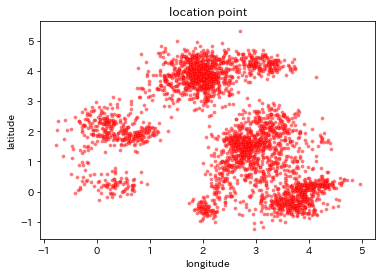

In [5]:
##locationの経緯度とk近傍の生成
#locationの場所集合を生成
topic = 30
rate = np.random.dirichlet(np.repeat(2.0, topic), 1).reshape(-1)
point = np.dot(np.random.multinomial(1, rate, location), range(topic))

#経緯度を生成
longitude = np.array((0, 5)); latitude = np.array((0, 5))
geo_location0 = np.zeros((location, 2))
for j in range(topic):
    index = np.array(range(location))[point==j]
    mu = np.append(np.random.uniform(longitude[0], longitude[1], 1), np.random.uniform(latitude[0], latitude[1], 1))
    cov = np.diag(np.random.uniform(0.01, 0.15, 2))
    value = np.random.uniform(-0.7, 0.7, 1) * np.prod(np.sqrt(np.diag(cov)))
    cov[0, 1] = value; cov[1, 0] = value
    geo_location0[index, :] = np.random.multivariate_normal(mu, cov, index.shape[0])

geo_location = np.min(geo_location0) + geo_location0
plt.scatter(geo_location[:, 0], geo_location[:, 1], s=3, c="pink", alpha=0.5, linewidths="2",
            edgecolors="red")
plt.title("location point")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.show()

#k近傍のlocationを取得
epsilon = 0.5
pattern = np.array([[True, True], [True, False], [False, False], [False, True]])
way_n = pattern.shape[0] 
neighbor_id = np.zeros((location, target), dtype="int") 
neighbor_dist = np.zeros((location, target))
neighbor_way = np.zeros((location, target), dtype="int")

for i in range(location):
    index1 = np.delete(np.arange(location), i)
    distance = np.exp(-np.sqrt(np.sum(np.power(geo_location[i, ] - geo_location[index1, ], 2), axis=1)) / epsilon) 
    sortlist = np.argsort(distance)[::-1]
    neighbor_id[i, ] = index1[sortlist[:target]]
    neighbor_dist[i, ] = distance[sortlist[:target]]
    ways = geo_location[i, ] - geo_location[index1[sortlist[:target]], ]
    for j in range(pattern.shape[0]):
        index2 = np.where(np.sum(np.array((ways > 0)==pattern[j, ], dtype="int"), axis=1)==2)[0]
        neighbor_way[i, index2] = j
    
#方角のインデックス
ways_list = [j for j in range(target)]
for i in range(target):
    temp_list = [i for i in range(way_n)]
    for j in range(way_n):
        temp_list[j] = np.array(np.where(neighbor_way[:, i]==j)[0], dtype="int")
    ways_list[i] = temp_list

In [6]:
##locationの割当を生成
#セグメント割当を生成
topic = 25
phi = np.random.dirichlet(np.repeat(0.5, location), topic)
theta = np.random.dirichlet(np.repeat(1.0, topic), hh)

#多項分布からアイテムを生成
z = np.repeat(0, hhpt)
location_id = np.zeros(hhpt, dtype='int')
for i in range(hh):
    if i%1000==0:
        print(i)
    z[d_list[i]] = np.dot(np.random.multinomial(1, theta[i, ], pt[i]), np.arange(topic))
    location_id[d_list[i]] = np.array(rmnom(phi[z[d_list[i]], ], pt[i], location, np.arange(pt[i]), 0), dtype="int")

#インデックスを取得
location_list = [i for i in range(location)]
location_n = np.repeat(0, location)
for i in range(location):
    location_list[i] = np.array(np.where(location_id==i)[0], dtype="int")
    location_n[i] = location_list[i].shape[0]  

0
1000
2000
3000
4000


In [7]:
##時間割当の生成
#パラメータを生成
phi_hour = np.random.dirichlet(np.repeat(1.0, day), topic)
phi_day = np.random.dirichlet(np.repeat(1.0, week), topic)
phi_month = np.random.dirichlet(np.repeat(1.0, year), topic)
phi_year = np.random.dirichlet(np.repeat(1.0, m), topic)

#多項分布から時間割当を生成
date_id = np.repeat(np.nan, hhpt)
hour_id = np.array(rmnom(phi_hour[z, ], hhpt, day, np.arange(hhpt), 0), dtype="int")
day_id = np.array(rmnom(phi_day[z, ], hhpt, week, np.arange(hhpt), 0), dtype="int")
month_id = np.array(rmnom(phi_month[z, ], hhpt, year, np.arange(hhpt), 0), dtype="int")
year_id = np.array(rmnom(phi_year[z, ], hhpt, m, np.arange(hhpt), 0), dtype="int")
for i in range(hhpt):
    if i%100000==0:
        print(i)
    index = np.where(((hour_id0==hour_id[i]) & (day_id0==day_id[i]) & (month_id0==month_id[i]) & (year_id0==year_id[i])))[0]
    date_id[i] = index[np.argmax(np.random.multinomial(1, np.repeat(1/index.shape[0], index.shape[0]), 1))]
date_id = np.array(date_id, dtype="int")

#インデックスを取得
date_list = [i for i in range(date)]
date_n = np.repeat(0, date)
for i in range(date):
    date_list[i] = np.array(np.where(date_id==i)[0], dtype="int")
    date_n[i] = date_list[i].shape[0]  

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000


In [8]:
####応答変数を生成####
per_min = 175; per_max = 175
rp = 0
while True:
    rp = rp + 1
    
    ##パラメータの生成
    #階層モデルの事前分布の生成
    alpha_u = np.repeat(0.0, k1)
    alpha_v = np.zeros((k1, k1, way_n))
    for j in range(way_n):
        alpha_v[:, :, j] = np.random.normal(0, 0.1, k1*k1).reshape(k1, k1)
    alpha_h = np.random.multivariate_normal(np.repeat(0.0, k2), np.diag(np.repeat(0.1, k2)), day) 
    alpha_d = np.random.multivariate_normal(np.repeat(1.0, k2), np.diag(np.repeat(0.1, k2)), week) 
    alpha_m = np.random.multivariate_normal(np.repeat(1.0, k2), np.diag(np.repeat(0.1, k2)), year) 
    omega = np.random.normal(0, 0.3, k1*k2).reshape(k2, k1)
    tau_u = np.array([0.75])
    tau_v = np.array([0.75])
    Cov_u = np.diag(np.repeat(0.5, k1))
    Cov_v = np.diag(np.repeat(0.1, k1))
    Cov_d = np.diag(np.repeat(0.1, k1))
    alphat_u = alpha_u.copy(); alphat_v = alpha_v.copy()
    alphat_h = alpha_h.copy(); alphat_d = alpha_d.copy(); alphat_m = alpha_m.copy(); omegat = omega.copy()
    taut_u = tau_u.copy(); taut_v = tau_v.copy(); Covt_u = Cov_u.copy(); Covt_v = Cov_v.copy(); Covt_d = Cov_d.copy()

    #モデルパラメータの生成
    Sigma = np.array([1.0])
    beta = np.array([-1.0])
    beta_u = np.random.normal(0, tau_u, hh)
    beta_v = np.random.normal(0, tau_v, location)
    theta_u = np.random.multivariate_normal(alpha_u, Cov_u, hh)
    betat = beta.copy(); betat_u = beta_u.copy(); betat_v = beta_v.copy(); thetat_u = theta_u.copy()
    
    #locationの特徴行列を生成
    theta_v0 = np.random.multivariate_normal(np.repeat(0.0, k1), np.diag(np.repeat(0.1, k1)), location)
    mu_location = np.zeros((location, k1))
    for i in range(target):
        for j in range(way_n):
            index = ways_list[i][j]
            mu_location[index, ] += np.dot(theta_v0[neighbor_id[index, i], ] * neighbor_dist[index, i][:, np.newaxis], alpha_v[:, :, j])
    theta_v = mu_location + np.random.multivariate_normal(np.repeat(1.0, k1), Cov_v, location)
    mut_location = mu_location.copy(); thetat_v0 = theta_v0.copy(); thetat_v = theta_v.copy()
    
    #時間の特徴行列を生成
    mu_date = np.dot(alpha_h[hour_id0, ] * alpha_d[day_id0, ] * alpha_m[month_id0, ], omega)
    theta_d = mu_date + np.random.multivariate_normal(np.repeat(1.0, k1), Cov_d, date)
    thetat_d = theta_d.copy()
    
    ##正規分布から応答変数を生成
    #テンソル分解の期待値
    beta_mu = beta + beta_u[d_id] + beta_v[location_id]
    uv = np.sum(theta_u[d_id, ] * theta_v[location_id, ] * theta_d[date_id, ], axis=1)
    mu = beta_mu + uv

    #潜在効用から二値変数を生成
    U = np.random.normal(mu, Sigma, hhpt)
    y = (U >= 0)*1 + (U < 0)*0
    Prob = norm.cdf(mu, 0, Sigma)

    #break条件
    print([rp, np.round(np.mean(y), 3)])
    if ((np.mean(y) > 0.2) & (np.mean(y) < 0.4) & (np.sum(U <= -10.0) < hhpt/per_min) & (np.sum(U > 10.0) < hhpt/per_max)):
        break

[1, 0.37]


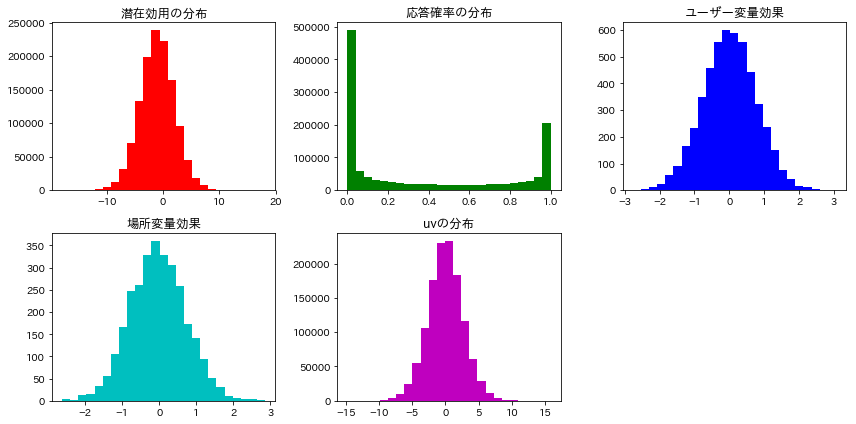

In [9]:
#潜在変数ごとのヒストグラム
UT = U.copy()
dt = [U, Prob, beta_u, beta_v, uv]
fig_range = np.append(np.array([np.min(U), 0, np.min(beta_u), np.min(beta_v), np.min(uv)]), 
                      np.array([np.max(U), 1.0, np.max(beta_u), np.max(beta_v), np.max(uv)])).reshape(2, len(dt))
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
legend = ["潜在効用の分布", "応答確率の分布", "ユーザー変量効果", "場所変量効果", "uvの分布"]
fig = plt.figure(figsize=(12.0, 6.0))
for j in range(len(dt)):
    ax = fig.add_subplot(2, 3, j+1)
    ax.hist(dt[j],  bins=25, range=(fig_range[0, j], fig_range[1, j]), color=colorlist[j])
    plt.title(legend[j], fontsize=12.5)
fig.tight_layout()
plt.show()

In [10]:
####マルコフ連鎖モンテカルロ法でパラメータを推定####
##切断正規分布の乱数を発生させる関数
def rtnorm(mu, sigma, a, b, n):
    FA = norm.cdf(a, mu, sigma)
    FB = norm.cdf(b, mu, sigma)
    return norm.ppf(np.random.uniform(0, 1, n)*(FB-FA)+FA, mu, sigma)

In [11]:
##ベイジアン多変量回帰モデルをギブスサンプリングする関数
def rmultireg(Y, X, inv_XXV, XY, Cov, ADelta, Deltabar, V, nu, n, col, k, flag):
    #事後分布のパラメータを設定
    beta_mu = np.dot(inv_XXV, XY + np.dot(ADelta, Deltabar)).T.reshape(-1)   #平均ベクトル
    sigma = np.kron(Cov, inv_XXV)   #分散共分散行列

    #パラメータをサンプリング
    beta_vec = np.random.multivariate_normal(beta_mu, sigma, 1)
    beta = beta_vec.reshape(col, k, order='F')   #回帰行列に変換
    if flag==1:
        return beta
    
    ##逆ウィシャート分布から分散共分散行列をサンプリング
    #モデル誤差を設定
    mu = np.dot(X, beta)
    er = Y - mu

    #逆ウィシャート分布のパラメータ
    IW_R = np.dot(er.T, er) + V
    Sn = n + nu

    #パラメータをサンプリング
    Cov = scipy.stats.invwishart.rvs(Sn, IW_R, 1)
    return beta, Cov

In [12]:
##アルゴリズムの設定
k = 10
R = 2000
keep = 2
burnin = int(500/keep)
iter = 0
disp = 10
target_iter = 50

In [13]:
##データの設定
#切断領域を定義
rho = 100.0
a = (1-y)*(-rho) + y*0
b = y*rho + (1-y)*0

#定数を定義
intercept = np.repeat(1.0, hhpt)[:, np.newaxis]
allocation_index = np.array([np.delete(np.arange(way_n), j) for j in range(way_n)])

#日付のインデックス
date_list0 = [i for i in range(date_n0.shape[0])]
for i in range(date_n0.shape[0]):
    temp_list = [i for i in range(date_n0[i])]
    for j in range(date_n0[i]):
        temp_list[j] = np.array(np.where(date_id0[:, i]==j)[0], dtype="int")
    date_list0[i] = temp_list
    
#日付の多重インデックス
allocation = np.array([np.delete(np.arange(date_n0.shape[0]), j) for j in range(date_n0.shape[0])])
date_list1 = [i for i in range(date_n0.shape[0])]
date_list2 = [i for i in range(date_n0.shape[0])]
for i in range(date_n0.shape[0]):
    temp_list1 = [i for i in range(date_n0[i])]
    temp_list2 = [i for i in range(date_n0[i])]
    for j in range(date_n0[i]):
        index = date_list0[i][j]
        temp_list1[j] = date_id0[:, allocation[i, ]][np.repeat(index, k1), ]
        temp_list2[j] = np.tile(np.arange(k), index.shape[0])
    date_list1[i] = temp_list1
    date_list2[i] = temp_list2

In [14]:
##事前分布の設定
#階層モデルの事前分布の設定
Deltabar1 = np.zeros((k1, k1))
Deltabar2 = np.zeros((k2, k1))
ADelta1 = 10 * np.diag(np.ones(k1))
ADelta2 = 1.0 * np.diag(np.ones(k2))
nu1 = 1.0
nu2 = 1.0
V1 = 0.1 
V2 = 0.1 
tau_d = np.diag(np.repeat(0.5, k2))
inv_tau_d = np.linalg.inv(tau_d)

#モデルパラメータの事前分布
tau = 100
s0 = 1.0
v0 = 1.0

In [15]:
##パラメータの真値
#階層モデルのパラメータの真値
alpha_u = alphat_u.copy()
alpha_v = alphat_v.copy()
alpha_h = alphat_h.copy()
alpha_d = alphat_d.copy()
alpha_m = alphat_m.copy()
omega = omegat.copy()
mu_location = mut_location.copy()
mu_date = np.dot(alpha_h[hour_id0, ] * alpha_d[day_id0, ] * alpha_m[month_id0, ], omega)
tau_u = taut_u.copy(); inv_tau_u = 1 / tau_u
tau_v = taut_v.copy(); inv_tau_v = 1 / tau_v
Cov_u = Covt_u.copy(); inv_Cov_u = np.linalg.inv(Cov_u)
Cov_v = Covt_v.copy(); inv_Cov_v = np.linalg.inv(Cov_v)
Cov_d = Covt_d.copy(); inv_Cov_d = np.linalg.inv(Cov_d)

#モデルパラメータの真値
Sigma = np.array([1.0])
beta = betat.copy()
beta_u = betat_u.copy()
beta_v = betat_v.copy()
theta_u = thetat_u.copy()
theta_v = thetat_v.copy()
theta_d = thetat_d.copy()

#テンソル分解の期待値
beta_mu = beta + beta_u[d_id] + beta_v[location_id]
uv = np.sum(theta_u[d_id, ] * theta_v[location_id, ] * theta_d[date_id, ], axis=1)
mu = beta_mu + uv

In [16]:
##パラメータの初期値
#階層モデルのパラメータの初期値
alpha_u = np.repeat(0.0, k1)
alpha_v = np.random.normal(0, 0.1, k1*k1*way_n).reshape(k1, k1, way_n)
alpha_h = np.random.multivariate_normal(np.repeat(0.0, k2), np.diag(np.repeat(0.01, k2)), date_n0[0])
alpha_d = np.random.multivariate_normal(np.repeat(0.0, k2), np.diag(np.repeat(0.01, k2)), date_n0[1])
alpha_n = np.random.multivariate_normal(np.repeat(0.0, k2), np.diag(np.repeat(0.01, k2)), date_n0[2])
omega = np.random.normal(0, 0.1, k2*k1).reshape(k2, k1)
mu_location = mut_location.copy()
mu_date = np.dot(alpha_h[hour_id0, ] * alpha_d[day_id0, ] * alpha_m[month_id0, ], omega)
tau_u = np.array([0.5]); inv_tau_u = 1 / tau_u
tau_v = np.array([1.0]); inv_tau_v = 1 / tau_v
Cov_u = np.diag(np.repeat(0.5, k1)); inv_Cov_u = np.linalg.inv(Cov_u)
Cov_v = np.diag(np.repeat(0.25, k1)); inv_Cov_v = np.linalg.inv(Cov_v)
Cov_d = np.diag(np.repeat(0.25, k1)); inv_Cov_d = np.linalg.inv(Cov_d)

#モデルパラメータの初期値
Sigma = np.array([1.0])
beta = np.array([-1.0])
beta_u = np.random.normal(0, 0.5, hh)
beta_v = np.random.normal(0, 0.5, location)
theta_u = np.random.multivariate_normal(np.repeat(0.0, k1), np.diag(np.repeat(0.2, k1)), hh)
theta_v = np.random.multivariate_normal(np.repeat(1.0, k1), np.diag(np.repeat(0.2, k1)), location)
theta_d = np.random.multivariate_normal(np.repeat(1.0, k1), np.diag(np.repeat(0.2, k1)), date)

#テンソル分解の期待値
beta_mu = beta + beta_u[d_id] + beta_v[location_id]
uv = np.sum(theta_u[d_id, ] * theta_v[location_id, ] * theta_d[date_id, ], axis=1)
mu = beta_mu + uv

In [17]:
##パラメータの格納用配列
#階層モデルのパラメータの格納用配列
ALPHA_V = np.zeros((k1, k1, way_n, int(R/keep)))
ALPHA_H = np.zeros((day, k2, int(R/keep)))
ALPHA_D = np.zeros((week, k2, int(R/keep)))
ALPHA_M = np.zeros((year, k2, int(R/keep)))
OMEGA = np.zeros((k2, k1, int(R/keep)))
TAU_U = np.zeros((int(R/keep), hh))
TAU_V = np.zeros((int(R/keep), location))
COV_U = np.zeros((k1, k1, int(R/keep)))
COV_V = np.zeros((k1, k1, int(R/keep)))
COV_D = np.zeros((k1, k1, int(R/keep)))

#モデルパラメータの格納用配列
BETA = np.repeat(0.0, int(R/keep))
BETA_U = np.zeros((int(R/keep), hh))
BETA_V = np.zeros((int(R/keep), location))
THETA_U = np.zeros((hh, k1, int(R/keep)))
THETA_V = np.zeros((location, k1, int(R/keep)))
THETA_D = np.zeros((date, k1, int(R/keep)))

In [18]:
##対数尤度の基準値
#学習データに対する1パラメータでの対数尤度
LLst = np.sum(y*np.log(np.mean(y))) + np.sum((1-y)*np.log(np.mean(1-y)))
print(LLst)

#学習データに対する真値での対数尤度
beta_mu = betat + betat_u[d_id] + betat_v[location_id]
uv = np.sum(thetat_u[d_id, ] * thetat_v[location_id, ] * thetat_d[date_id, ], axis=1)
mu = beta_mu + uv
Prob = norm.cdf(mu, 0, Sigma)
Prob[Prob==1.0] = 0.9999999999; Prob[Prob==0] = np.power(10.0, -100)
LLbest = np.sum(y*np.log(Prob)) + np.sum((1-y)*np.log(1-Prob))
print(LLbest)

-821782.0232902372
-285076.06969966576


In [19]:
####ギブスサンプリングでパラメータをサンプリング####
for rp in range(R):
    
    ##切断正規分布から潜在効用を生成
    #テンソル分解の期待値
    beta_user = beta_u[d_id]; beta_location = beta_v[location_id]
    theta_user = theta_u[d_id, ]; theta_location = theta_v[location_id, ]; theta_date = theta_d[date_id, ]
    beta_mu = beta + beta_user + beta_location
    uv = np.dot(theta_user * theta_location * theta_date, k_vec1)
    mu = beta_mu + uv

    #潜在効用を生成
    U = rtnorm(mu, Sigma, a, b, hhpt)   
    U[np.isinf(U)] = 0
    
    ##期待値パラメータをサンプリング
    #モデル誤差を定義
    er_y = U - beta_user - beta_location - uv

    #正規分布から事後分布をサンプリング
    weights = tau / (Sigma/hhpt + tau)
    mu_par = weights * np.mean(er_y)
    beta = np.random.normal(mu_par, weights*Sigma/hhpt, 1)
    

    ##ユーザーパラメータをサンプリング
    #モデル誤差を定義
    er_y = U - beta - beta_location
    X = np.hstack((intercept, theta_location * theta_date))
    alpha = np.append(0, alpha_u)
    inv_Cov = np.diag(np.append(inv_tau_u, np.diag(inv_Cov_u)))

    #事後分布のパラメータ
    for i in range(hh):
        index = d_list[i]
        u = er_y[index]; x = X[index, ]
        xy = np.dot(x.T, u)
        xxv = np.dot(x.T, x) + inv_Cov
        inv_xxv = np.linalg.inv(xxv)
        theta_mu = np.dot(inv_xxv, xy + np.dot(inv_Cov, alpha))

        #多変量正規分布からパラメータをサンプリング
        out = np.random.multivariate_normal(theta_mu, Sigma*inv_xxv, 1).reshape(-1)
        beta_u[i] = out[0]
        theta_u[i, ] = out[1:]
        
    #パラメータを更新
    beta_user = beta_u[d_id]
    theta_user = theta_u[d_id, ]
    
    
    ##ロケーションパラメータをサンプリング
    #モデル誤差を定義
    er_y = U - beta - beta_user
    X = np.hstack((intercept, theta_user * theta_date))
    inv_Cov = np.diag(np.append(inv_tau_v, np.diag(inv_Cov_v)))

    #事後分布のパラメータ
    for i in range(location):
        index = location_list[i]
        alpha = np.append(0, mu_location[i, ])
        u = er_y[index]; x = X[index, ]
        xy = np.dot(x.T, u)
        xxv = np.dot(x.T, x) + inv_Cov
        inv_xxv = np.linalg.inv(xxv)
        theta_mu = np.dot(inv_xxv, xy + np.dot(inv_Cov, alpha))

        #多変量正規分布からパラメータをサンプリング
        out = np.random.multivariate_normal(theta_mu, Sigma*inv_xxv, 1).reshape(-1)
        beta_v[i] = out[0]
        theta_v[i, ] = out[1:]
    
    #パラメータの更新
    beta_location = beta_v[location_id]
    theta_location = theta_v[location_id, ]
    
    
    ##時間パラメータをサンプリング
    #モデル誤差を定義
    er_y = U - beta - beta_user - beta_location
    X = theta_user * theta_location

    #事後分布のパラメータ
    for i in range(date):
        index = date_list[i]
        u = er_y[index]; x = X[index, ]
        xy = np.dot(x.T, u)
        xxv = np.dot(x.T, x) + inv_Cov_d
        inv_xxv = np.linalg.inv(xxv)
        theta_mu = np.dot(inv_xxv, xy + np.dot(inv_Cov_d, mu_date[i, ]))

        #多変量正規分布からパラメータをサンプリング
        theta_d[i, ] = np.random.multivariate_normal(theta_mu, Sigma*inv_xxv, 1).reshape(-1)

    #パラメータを更新
    theta_date = theta_d[date_id, ]
    
    
    ##場所の階層モデルのパラメータをサンプリング
    #変数の割当を定義
    mu_allocation1 = np.zeros((location, k1, way_n))
    mu_allocation2 = np.zeros((location, k1, way_n))
    for i in range(target):
        for j in range(way_n):
            index = ways_list[i][j]
            weight_dist = theta_v0[neighbor_id[index, i], ] * neighbor_dist[index, i][:, np.newaxis]
            mu_allocation1[index, :, j] += weight_dist
            mu_allocation2[index, :, j] += np.dot(weight_dist, alpha_v[:, :, j])

    #多変量回帰モデルから事後分布をサンプリング
    for j in range(way_n):
        er_y = theta_v - np.sum(mu_allocation2[:, :, allocation_index[j, ]], axis=2)
        x = mu_allocation1[:, :, j]
        xy = np.dot(x.T, er_y)
        inv_xxv = np.linalg.inv(np.dot(x.T, x) + ADelta1)
        alpha_v[:, :, j] = rmultireg(er_y, x, inv_xxv, xy, Cov_v, ADelta1, Deltabar1, V1, nu1, location, k1, k1, 1)

    #モデル期待値を更新
    mu_location = np.zeros((location, k1))
    for i in range(target):
        for j in range(way_n):
            index = ways_list[i][j]
            mu_location[index, ] += np.dot(theta_v0[neighbor_id[index, i], ] * neighbor_dist[index, i][:, np.newaxis], alpha_v[:, :, j])

    #分散共分散行列をサンプリング
    beta_vec = np.repeat(np.mean(beta_v), location)[:, np.newaxis]
    er = np.hstack((beta_v[:, np.newaxis], theta_v)) - np.hstack((beta_vec, mu_location))
    IW_R = np.dot(er.T, er) + V1
    Sn = location + nu1
    out = scipy.stats.invwishart.rvs(Sn, IW_R, 1)
    tau_v = out[0, 0]
    Cov_v = np.diag(np.diag(out)[1:])
    inv_tau_ = 1 / tau_v
    inv_Cov_v = np.linalg.inv(Cov_v)


    ##時間の階層モデルのパラメータをサンプリング
    #日周期の特徴ベクトルをサンプリング
    Cov_mu = np.mean(np.diag(Cov_d))
    for j in range(date_n0[0]):
        index = date_list0[0][j]
        u = theta_d[index, ].reshape(-1)
        x = alpha_d[date_list1[0][j][:, 0], ] * alpha_m[date_list1[0][j][:, 1], ] * (omega.T)[date_list2[0][j], ]
        xy = np.dot(x.T, u)
        inv_xxv = np.linalg.inv(np.dot(x.T, x) + inv_tau_d)
        alpha_mu = np.dot(inv_xxv, xy)
        alpha_h[j, ] = np.random.multivariate_normal(alpha_mu, inv_xxv*Cov_mu, 1).reshape(-1)

    #週周期の特徴ベクトルをサンプリング
    for j in range(date_n0[1]):
        index = date_list0[1][j]
        u = theta_d[index, ].reshape(-1)
        x = alpha_h[date_list1[1][j][:, 0], ] * alpha_m[date_list1[1][j][:, 1], ] * (omega.T)[date_list2[1][j], ]
        xy = np.dot(x.T, u)
        inv_xxv = np.linalg.inv(np.dot(x.T, x) + inv_tau_d)
        alpha_mu = np.dot(inv_xxv, xy)
        alpha_d[j, ] = np.random.multivariate_normal(alpha_mu, inv_xxv*Cov_mu, 1).reshape(-1)

    #月周期の特徴ベクトルをサンプリング
    for j in range(date_n0[2]):
        index = date_list0[2][j]
        u = theta_d[index, ].reshape(-1)
        x = alpha_h[date_list1[2][j][:, 0], ] * alpha_d[date_list1[2][j][:, 1], ] * (omega.T)[date_list2[2][j], ]
        xy = np.dot(x.T, u)
        inv_xxv = np.linalg.inv(np.dot(x.T, x) + inv_tau_d)
        alpha_mu = np.dot(inv_xxv, xy)
        alpha_m[j, ] = np.random.multivariate_normal(alpha_mu, inv_xxv*Cov_mu, 1).reshape(-1)

    #回帰行列の事後分布をサンプリング
    u = theta_d.copy()
    x = alpha_h[hour_id0, ] * alpha_d[day_id0, ] * alpha_m[month_id0, ]
    xy = np.dot(x.T, u)
    inv_xxv = np.linalg.inv(np.dot(x.T, x) + ADelta2) 
    omega = rmultireg(u, x, inv_xxv, xy, Cov_d, ADelta2, Deltabar2, V2, nu2, date, k2, k1, 1)
    mu_date = np.dot(alpha_h[hour_id0, ] * alpha_d[day_id0, ] * alpha_m[month_id0, ], omega)
    
    #分散共分散行列の事後分布をサンプリング
    er = theta_d - mu_date
    IW_R = np.dot(er.T, er) + V1
    Sn = date + nu1
    out = scipy.stats.invwishart.rvs(Sn, IW_R, 1)
    Cov_d = np.diag(np.diag(out))
    inv_Cov_d = np.linalg.inv(Cov_d)

    
    ##サンプリング結果の格納と表示
    #サンプリング結果の格納
    if rp%keep==0:
        mkeep = int(rp/keep)
        ALPHA_V[:, :, :, mkeep] = alpha_v
        ALPHA_H[:, :, mkeep] = alpha_h
        ALPHA_D[:, :, mkeep] = alpha_d
        ALPHA_M[:, :, mkeep] = alpha_m
        OMEGA[:, :, mkeep] = omega
        TAU_U[mkeep, ] = tau_u
        TAU_V[mkeep, ] = tau_v
        COV_U[:, :, mkeep] = Cov_u
        COV_V[:, :, mkeep] = Cov_v
        COV_D[:, :, mkeep] = Cov_d
        BETA[mkeep] = beta
        BETA_U[mkeep, ] = beta_u
        BETA_V[mkeep, ] = beta_v
        THETA_U[:, :, mkeep] = theta_u
        THETA_V[:, :, mkeep] = theta_v
        THETA_D[:, :, mkeep] = theta_d

    if rp%disp==0:
        #学習データに対する対数尤度を更新
        beta_mu = beta + beta_u[d_id] + beta_v[location_id]
        uv = np.sum(theta_u[d_id, ] * theta_v[location_id, ] * theta_d[date_id, ], axis=1)
        mu = beta_mu + uv
        Prob = norm.cdf(mu, 0, Sigma)
        Prob[Prob==1.0] = 0.9999999999; Prob[Prob==0] = np.power(10.0, -100)
        LL = np.sum(y*np.log(Prob)) + np.sum((1-y)*np.log(1-Prob))

        #サンプリング結果を表示
        print(rp)
        print(np.round(np.array((LL, LLbest, LLst)), 1))
        print(np.round([np.mean(np.diag(Cov_u)), np.mean(np.diag(Cov_v)), np.mean(np.diag(Cov_d))], 3))

0
[-694714.5 -285076.1 -821782. ]
[0.5   0.975 0.221]
10
[-392344.7 -285076.1 -821782. ]
[0.5   0.474 0.081]
20
[-343175.4 -285076.1 -821782. ]
[0.5   0.364 0.087]
30
[-326738.  -285076.1 -821782. ]
[0.5   0.336 0.108]
40
[-319615.3 -285076.1 -821782. ]
[0.5   0.331 0.124]
50
[-316410.6 -285076.1 -821782. ]
[0.5   0.323 0.141]
60
[-312814.1 -285076.1 -821782. ]
[0.5   0.323 0.148]
70
[-310581.6 -285076.1 -821782. ]
[0.5   0.33  0.157]
80
[-308834.  -285076.1 -821782. ]
[0.5   0.309 0.162]
90
[-306985.8 -285076.1 -821782. ]
[0.5   0.318 0.172]
100
[-305785.2 -285076.1 -821782. ]
[0.5   0.325 0.17 ]
110
[-305123.2 -285076.1 -821782. ]
[0.5   0.327 0.169]
120
[-303058.1 -285076.1 -821782. ]
[0.5   0.323 0.178]
130
[-302211.1 -285076.1 -821782. ]
[0.5   0.333 0.185]
140
[-301835.1 -285076.1 -821782. ]
[0.5   0.353 0.182]
150
[-300664.5 -285076.1 -821782. ]
[0.5   0.362 0.183]
160
[-299534.7 -285076.1 -821782. ]
[0.5   0.357 0.188]
170
[-298570.1 -285076.1 -821782. ]
[0.5   0.365 0.189]
180

1460
[-288751.6 -285076.1 -821782. ]
[0.5   0.578 0.191]
1470
[-288969.7 -285076.1 -821782. ]
[0.5   0.577 0.19 ]
1480
[-288792.6 -285076.1 -821782. ]
[0.5   0.556 0.188]
1490
[-288872.1 -285076.1 -821782. ]
[0.5   0.566 0.19 ]
1500
[-288794.4 -285076.1 -821782. ]
[0.5   0.579 0.185]
1510
[-289255.6 -285076.1 -821782. ]
[0.5   0.559 0.185]
1520
[-288875.8 -285076.1 -821782. ]
[0.5   0.566 0.185]
1530
[-288787.9 -285076.1 -821782. ]
[0.5   0.567 0.183]
1540
[-288365.5 -285076.1 -821782. ]
[0.5   0.565 0.187]
1550
[-288426.6 -285076.1 -821782. ]
[0.5   0.568 0.184]
1560
[-289124.  -285076.1 -821782. ]
[0.5   0.575 0.19 ]
1570
[-289166.  -285076.1 -821782. ]
[0.5   0.595 0.184]
1580
[-289138.4 -285076.1 -821782. ]
[0.5   0.583 0.183]
1590
[-289110.  -285076.1 -821782. ]
[0.5   0.564 0.182]
1600
[-289426.7 -285076.1 -821782. ]
[0.5  0.56 0.18]
1610
[-289048.4 -285076.1 -821782. ]
[0.5   0.568 0.179]
1620
[-289203.6 -285076.1 -821782. ]
[0.5   0.559 0.182]
1630
[-288959.  -285076.1 -821782.